[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)
[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="200">](https://github.com/neuromorphs/tonic/)


# Training on ST-MNIST with Tonic + snnTorch Tutorial

##### By Dylan Louie (djlouie@ucsc.edu), Hannah Cohen Sandler (hcohensa@ucsc.edu), Shatoparba Banerjee (sbaner12@ucsc.edu)

<a href="https://colab.research.google.com/drive/1P2yQCDmp7TilNrEqj_cBzS7vscIs0L_o?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In [1]:
!pip install tonic --quiet
!pip install snntorch --quiet
!pip install torchdata --upgrade  # Try updating torchdata to the newest version
# or
!pip install torchdata==0.6.0 # Try installing a version known to include datapipes, 0.6.0 is known to work
!pip install --upgrade torch torchvision torchaudio

  Using cached torchdata-0.10.0-py3-none-any.whl.metadata (6.0 kB)
Using cached torchdata-0.10.0-py3-none-any.whl (57 kB)
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.6.0
    Uninstalling torchdata-0.6.0:
      Successfully uninstalled torchdata-0.6.0
  Using cached torchdata-0.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (919 bytes)
Using cached torchdata-0.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.10.0
    Uninstalling torchdata-0.10.0:
      Successfully uninstalled torchdata-0.10.0
  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manyl

In [2]:
# tonic imports
import tonic
from tonic.prototype.datasets import STMNIST  # Import STMNIST from tonic.datasets
import tonic.transforms as transforms  # Not to be mistaken with torchdata.transfroms
from tonic import DiskCachedDataset

# torch imports
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn

# snntorch imports
import snntorch as snn
from snntorch import surrogate
import snntorch.spikeplot as splt
from snntorch import functional as SF
from snntorch import utils

# other imports
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
import numpy as np
import torchdata
import os
from ipywidgets import IntProgress
import time
import statistics

In [3]:
#@title Plotting Settings
def print_frame(copy_events):
  print('----------------------------')
  print(copy_events[0])
  print('----------------------------')
  print(copy_events[0][0])
  print('----------------------------')
  print(copy_events[0][0][0])

# 1. The ST-MNIST Dataset

## 1.1 Introduction

The Spiking Tactile-MNIST (ST-MNIST) dataset features handwritten digits (0-9) inscribed by 23 individuals on a 100-taxel biomimetic event-based tactile sensor array. This dataset captures the dynamic pressure changes associated with natural writing. The tactile sensing system, Asynchronously Coded Electronic Skin (ACES), emulates the human peripheral nervous system, transmitting fast-adapting (FA) responses as asynchronous electrical events.

More information about the ST-MNIST dataset can be found in the following paper:

> <cite> H. H. See, B. Lim, S. Li, H. Yao, W. Cheng, H. Soh, and B. C. K. Tee, "ST-MNIST - The Spiking Tactile-MNIST Neuromorphic Dataset," A PREPRINT, May 2020. [Online]. Available: https://arxiv.org/abs/2005.04319 </cite>

## 1.2 Downloading the ST-MNIST dataset

ST-MNIST is in the `MAT` format. Tonic can be used transform this into an event-based format (x, y, t, p).

1. Download the compressed dataset by accessing: https://scholarbank.nus.edu.sg/bitstream/10635/168106/2/STMNIST%20dataset%20NUS%20Tee%20Research%20Group.zip

2. The zip file is `STMNIST dataset NUS Tee Research Group`. Create a parent folder titled `STMNIST` and place the zip file inside.

3. If running in a cloud-based environment, e.g., on Colab, you will need to do this in Google Drive.

## 1.3 Mount to Drive
You may need to authorize the following to access Google Drive:

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After executing the cell above, Drive files will be present in "/content/drive/MyDrive". You may need to change the `root` file to your own path.

In [5]:
root = "/content/drive/My Drive/"  # similar to os.path.join('content', 'drive', 'My Drive')
os.listdir(os.path.join(root, 'STMNIST')) # confirm the file exists

['STMNIST dataset NUS Tee Research Group.zip']

## 1.4 ST-MNIST Using Tonic

`Tonic` will be used to convert the dataset into a format compatible with PyTorch/snnTorch. The documentation can be found [here](https://tonic.readthedocs.io/en/latest/generated/tonic.prototype.datasets.STMNIST.html#tonic.prototype.datasets.STMNIST).

In [6]:
dataset = tonic.prototype.datasets.STMNIST(root=root, keep_compressed = False, shuffle = False)

Tonic formats the STMNIST dataset into `(x, y, t, p)` tuples.
* `x` is the position on the x-axis
* `y` is the position on the y-axis
* `t` is a timestamp
* `p` is polarity; +1 if taxel pressed down, 0 if taxel released

Each sample also contains the label, which is an integer 0-9 that corresponds to what digit is being drawn.

An example of one of the events is shown below:

In [7]:
events, target = next(iter(dataset))
print(events[0])
print(target)

(1, 1, 199867, 0)
2


The `.ToFrame()` function from `tonic.transforms` transforms events from an (x, y, t, p) tuple to a numpy array matrix.

In [8]:
sensor_size = tuple(tonic.prototype.datasets.STMNIST.sensor_size.values())  # The sensor size for STMNIST is (10, 10, 2)

# filter noisy pixels and integrate events into 1ms frames
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=20000)
                                     ])

transformed_events = frame_transform(events)

print_frame(transformed_events)

----------------------------
[[[ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [10  0  0  0  0  0  0  0  0  0]
  [13  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 7  0  0  0  0  0  0  0  0  0]
  [ 3  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]]]
----------------------------
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  

## 1.5 Visualizations


Using `tonic.utils.plot_animation`, the frame transform, and also some rotation. We can create an animation of the data and visualize this.

In [9]:
# Iterate to a new iteration
events, target = next(iter(dataset))

Animation of ST-MNIST
The target label is: 7


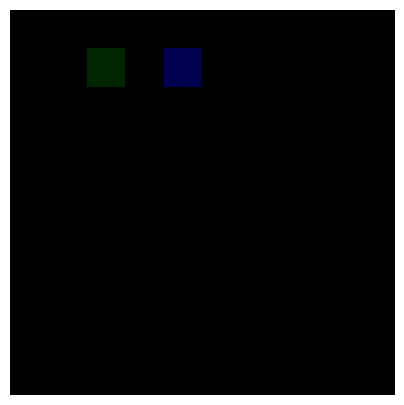

In [10]:
frame_transform_tonic_visual = tonic.transforms.ToFrame(
    sensor_size=(10, 10, 2),
    time_window=10000,
)

frames = frame_transform_tonic_visual(events)
frames = frames / np.max(frames)
frames = np.rot90(frames, k=-1, axes=(2, 3))
frames = np.flip(frames, axis=3)

# Print out the Target
print('Animation of ST-MNIST')
print('The target label is:',target)
animation = tonic.utils.plot_animation(frames)

# Display the animation inline in a Jupyter notebook
HTML(animation.to_jshtml())

We can also use `snntorch.spikeplot`

Animation of ST-MNIST
The target label is: 7


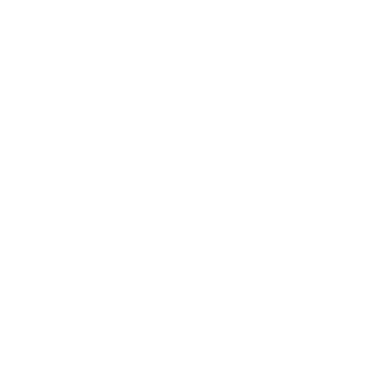

In [28]:
frame_transform_snntorch_visual = tonic.transforms.ToFrame(
    sensor_size=(10, 10, 2),
    time_window=8000,
)

tran = frame_transform_snntorch_visual(events)
tran = np.rot90(tran, k=-1, axes=(2, 3))
tran = np.flip(tran, axis=3)
tran = torch.from_numpy(tran)

tensor1 = tran[:, 0:1, :, :]
tensor2 = tran[:, 1:2, :, :]

print('Animation of ST-MNIST')
print('The target label is:',target)

fig, ax = plt.subplots()
time_steps = tensor1.size(0)
tensor1_plot = tensor1.reshape(time_steps, 10, 10)
anim = splt.animator(tensor1_plot, fig, ax, interval=10)

display(HTML(anim.to_html5_video()))

There is a total of 6953 recordings in this dataset. The developers of ST-MNIST invited 23 participants to write each 10 digit approx. 30 times each: 23\*30\*10 = 6,900.

In [12]:
print(len(dataset))

6953


## 1.6 Lets create a trainset and testset!

ST-MNIST isn't already seperated into a trainset and testset in Tonic. That means we will have to seperate it manually. In the process of seperating the data we will transform them using `.ToFrame()` as well.

In [13]:
sensor_size = tonic.prototype.datasets.STMNIST.sensor_size
sensor_size = tuple(sensor_size.values())

# Define a transform
frame_transform = transforms.Compose([transforms.ToFrame(sensor_size=sensor_size, time_window=20000)])

The following code reads out the a portion of the dataset, transforms the events using `frame_transform` defined above, and then seperates the data into a trainset and a testset. On top of that, `.ToFrame()` is applied each time. Thus, this code snippet might take a few minutes.

For speed, we will just use a subset of the dataset. By default, 640 training samples and 320 testing samples. Feel free to change this if you have more patience than us.

In [14]:
def shorter_transform_STMNIST(data, transform):
    short_train_size = 640
    short_test_size = 320

    train_bar = IntProgress(min=0, max=short_train_size)
    test_bar = IntProgress(min=0, max=short_test_size)

    testset = []
    trainset = []

    print('Porting over and transforming the trainset.')
    display(train_bar)
    for _ in range(short_train_size):
        events, target = next(iter(dataset))
        events = transform(events)
        trainset.append((events, target))
        train_bar.value += 1
    print('Porting over and transforming the testset.')
    display(test_bar)
    for _ in range(short_test_size):
        events, target = next(iter(dataset))
        events = transform(events)
        testset.append((events, target))
        test_bar.value += 1

    return (trainset, testset)

start_time = time.time()
trainset, testset = shorter_transform_STMNIST(dataset, frame_transform)
elapsed_time = time.time() - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes, seconds = divmod(elapsed_time, 60)
seconds, milliseconds = divmod(seconds, 1)
milliseconds = round(milliseconds * 1000)

# Print the elapsed time
print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

Porting over and transforming the trainset.


IntProgress(value=0, max=640)

Porting over and transforming the testset.


IntProgress(value=0, max=320)

Elapsed time: 3 minutes, 32 seconds, 843 milliseconds


## 1.6 Dataloading and Batching


In [15]:
# Create a DataLoader
dataloader = DataLoader(trainset, batch_size=32, shuffle=True)

For faster dataloading, we can use `DiskCashedDataset(...)` from Tonic.

Due to variations in the lengths of event recordings, `tonic.collation.PadTensors()` will be used to prevent irregular tensor shapes. Shorter recordings are padded, ensuring uniform dimensions across all samples in a batch.

In [16]:
transform = tonic.transforms.Compose([torch.from_numpy])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/stmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/stmnist/test')

batch_size = 32
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [17]:
# Query the shape of a sample: time x batch x dimensions
data_tensor, targets = next(iter(trainloader))
print(data_tensor.shape)

torch.Size([99, 32, 2, 10, 10])


## 1.7 Create the Spiking Convolutional Neural Network

Below we have by default a spiking convolutional neural network with the architecture: `10×10-32c4-64c3-MaxPool2d(2)-10o`.

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
beta = 0.95

# This is the same architecture that was used in the STMNIST Paper
scnn_net = nn.Sequential(
    nn.Conv2d(2, 32, kernel_size=4),
    snn.Leaky(beta=beta, init_hidden=True),
    nn.Conv2d(32, 64, kernel_size=3),
    snn.Leaky(beta=beta, init_hidden=True),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 2 * 2, 10),  # Increased size of the linear layer
    snn.Leaky(beta=beta, init_hidden=True, output=True)
).to(device)

optimizer = torch.optim.Adam(scnn_net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

## 1.8 Define the Forward Pass

In [19]:
def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(data.size(0)):  # data.size(0) = number of time steps

        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

## 1.9 Create and Run the Training Loop

This might take a while, so kick back, take a break and eat a snack while this happens; perhaps even count kangaroos to take a nap or do a shoey and get schwasted instead.

In [20]:
start_time = time.time()

num_epochs = 30

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        scnn_net.train()
        spk_rec = forward_pass(scnn_net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print loss every 4 iterations
        if i%4 == 0:
            print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        # Calculate accuracy rate and then append it to accuracy history
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        # Print accuracy every 4 iterations
        if i%4 == 0:
            print(f"Accuracy: {acc * 100:.2f}%\n")

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes, seconds = divmod(elapsed_time, 60)
seconds, milliseconds = divmod(seconds, 1)
milliseconds = round(milliseconds * 1000)

# Print the elapsed time
print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

Epoch 0, Iteration 0 
Train Loss: 9.27
Accuracy: 9.38%

Epoch 0, Iteration 4 
Train Loss: 8.41
Accuracy: 6.25%

Epoch 0, Iteration 8 
Train Loss: 7.76
Accuracy: 6.25%

Epoch 0, Iteration 12 
Train Loss: 4.94
Accuracy: 15.62%

Epoch 0, Iteration 16 
Train Loss: 3.33
Accuracy: 18.75%

Epoch 1, Iteration 0 
Train Loss: 4.28
Accuracy: 0.00%

Epoch 1, Iteration 4 
Train Loss: 3.75
Accuracy: 6.25%

Epoch 1, Iteration 8 
Train Loss: 3.53
Accuracy: 12.50%

Epoch 1, Iteration 12 
Train Loss: 3.53
Accuracy: 18.75%

Epoch 1, Iteration 16 
Train Loss: 3.29
Accuracy: 12.50%

Epoch 2, Iteration 0 
Train Loss: 3.27
Accuracy: 18.75%

Epoch 2, Iteration 4 
Train Loss: 3.30
Accuracy: 12.50%

Epoch 2, Iteration 8 
Train Loss: 3.08
Accuracy: 12.50%

Epoch 2, Iteration 12 
Train Loss: 3.08
Accuracy: 12.50%

Epoch 2, Iteration 16 
Train Loss: 3.12
Accuracy: 18.75%

Epoch 3, Iteration 0 
Train Loss: 3.22
Accuracy: 9.38%

Epoch 3, Iteration 4 
Train Loss: 3.29
Accuracy: 18.75%

Epoch 3, Iteration 8 
Train Los

Uncomment the code below if you want to save the model

In [31]:
# Your Google Drive folder ID
folder_id = '1SZrWQTwR7oq0pVRLypCbDXPIt-WwaX8z'

# Construct the save path
save_path = f'/content/drive/My Drive/UNARY/scnn_net.pth'

# Save the model
torch.save(scnn_net.state_dict(), save_path)

HOW TO USE

1. Load the model

In [ ]:
"""# Assuming you have the same model architecture (scnn_net) defined
   scnn_net = nn.Sequential(
       # ... (Your SCNN architecture) ...
   )

   # Load the saved state dictionary
   scnn_net.load_state_dict(torch.load('scnn_net.pth'))

   # Set to evaluation mode (important for inference)
   scnn_net.eval()
   """

2. Make predictions:

In [ ]:
'''
# Assuming you have new input data (data_tensor)
   with torch.no_grad(): # No need to calculate gradients during inference
       spk_rec = forward_pass(scnn_net, data_tensor) # Get spike recordings
       predictions = spk_rec.argmax(dim=1) # Get predicted labels (digits)
'''

# 2. Results

## 2.1 Plot accuracy history

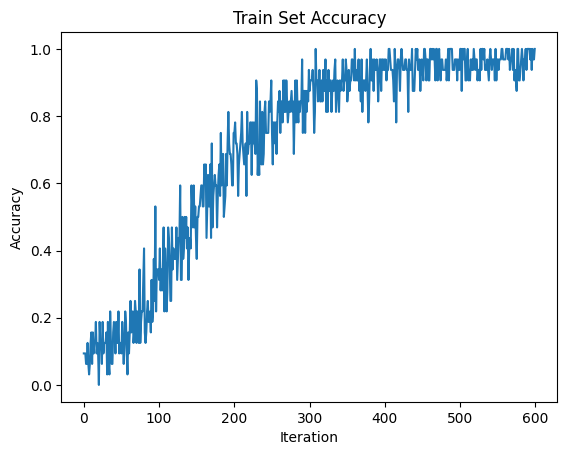

In [21]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## 2.2 Evaluate the Network on the Test Set

In [22]:
# Make sure your model is in evaluation mode
scnn_net.eval()

# Initialize variables to store predictions and ground truth labels
acc_hist = []

# Iterate over batches in the testloader
with torch.no_grad():
    for data, targets in testloader:
        # Move data and targets to the device (GPU or CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        spk_rec = forward_pass(scnn_net, data)

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        # if i%10 == 0:
        # print(f"Accuracy: {acc * 100:.2f}%\n")

print("The average loss across the testloader is:", statistics.mean(acc_hist))

The average loss across the testloader is: 0.75


## 2.3 Visualize Spike Recordings

The following visual is a spike count histogram for a single target and single piece of data using the spike recording list.

In [23]:
spk_rec = forward_pass(scnn_net, data)

The target label is: 3


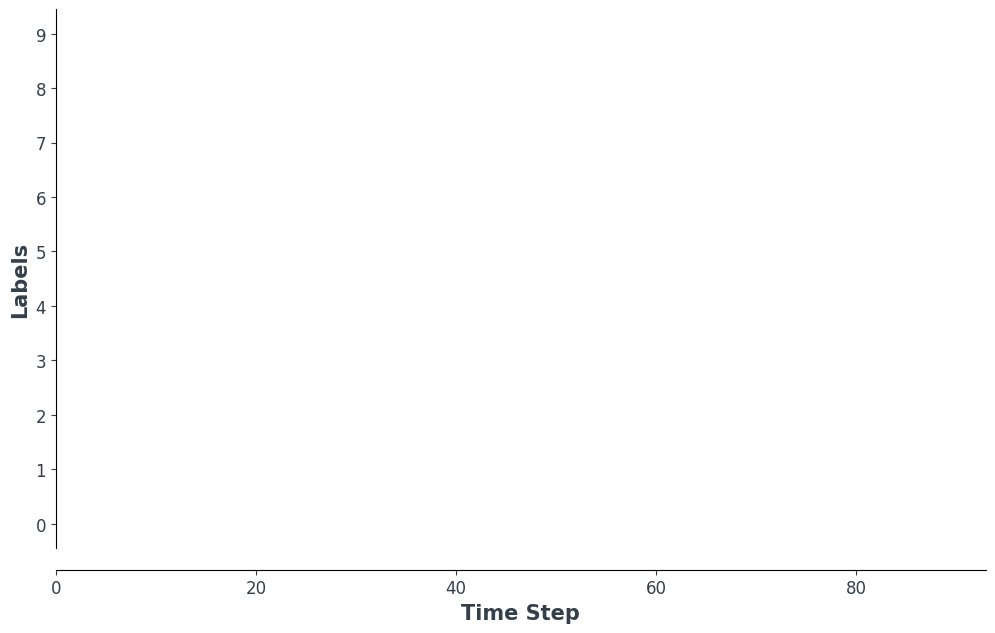

In [24]:
# Change index to visualize a different sample
idx = 0
fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

display(HTML(anim.to_html5_video()))
# anim.save("spike_bar.mp4")

# Congratulations!
You trained a Spiking CNN using `snnTorch` and `Tonic` on ST-MNIST!